In [1]:
import torch
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
from torch.utils.data import IterableDataset, DataLoader
from matplotlib import pyplot as plt
import math
from einops import rearrange
from tqdm import tqdm
from PIL import Image
from datasets import load_dataset
import requests
from io import BytesIO
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from torch.utils.data import IterableDataset
from datasets import load_dataset
from PIL import Image, UnidentifiedImageError
from io import BytesIO
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
from typing import Any, Tuple
import torchvision
from google.colab import drive
from huggingface_hub import login
import os

In [2]:
# To save the palette to drive after it finishes
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install --upgrade datasets fsspec huggingface_hub


  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [4]:
login() # login to hugging face specifically for colab


In [7]:
class LaionStreamDataset(IterableDataset):
    """
    Streaming dataset. Stores a buffer of images and captions for next batch use.
    - max_items: The maximum items to store in the buffer (image, caption). Sometimes the buffer can go beyond that for performance reasons and threading, but we try to keep it to this length.
    """
    def __init__(self, transform=None, max_items=64, num_threads=8):
        self.dataset = load_dataset("laion/laion2B-en", streaming=True, split="train")
        self.transform = transform
        self.max_items = max_items
        self.num_threads = num_threads
        self.buffer = []

        # Shared counters
        self.lock = threading.Lock()
        self.valid_images = 0
        self.invalid_images = 0

    def download_and_process(self, example: dict) -> Tuple[Any, str]:
        """
        Given a dataset item (with URL and caption), downloads and returns the image and caption.
        Returns None on failure.
        """
        try:
            url = example["url"]
            caption = example["caption"]

            response = requests.get(url, timeout=5, stream=True)
            if response.status_code != 200 or "image" not in response.headers.get("Content-Type", ""):
                with self.lock:
                    self.invalid_images += 1
                return None

            try:
                image = Image.open(BytesIO(response.content))
                image.verify()
                image = Image.open(BytesIO(response.content)).convert("RGB")
            except (UnidentifiedImageError, OSError):
                with self.lock:
                    self.invalid_images += 1
                return None

            if self.transform:
                image = self.transform(image)

            with self.lock:
                self.valid_images += 1

            return image, caption

        except Exception:
            with self.lock:
                self.invalid_images += 1
            return None

    def __iter__(self):
        data_iter = iter(self.dataset)

        def fill_buffer():
            """
            Fills the buffer up to max_items using threading.
            """
            needed = self.max_items - len(self.buffer)
            if needed <= 0:
                return

            examples = []
            for _ in range(needed * 2):  # Grab more to account for failures
                try:
                    examples.append(next(data_iter))
                except StopIteration:
                    break

            with ThreadPoolExecutor(max_workers=self.num_threads) as executor:
                futures = [executor.submit(self.download_and_process, ex) for ex in examples]
                for future in as_completed(futures):
                    result = future.result()
                    if result is not None:
                        self.buffer.append(result)
                        if len(self.buffer) >= self.max_items:
                            break

            if len(self.buffer) < self.max_items:
              print(f"[Warning] Buffer only filled to {len(self.buffer)} of {self.max_items} due to image download failures.")

        # Initial fill
        fill_buffer()

        while True:
            # Refill if buffer is low
            if len(self.buffer) < self.max_items // 2:
                fill_buffer()

            if not self.buffer:
                break  # Nothing more to yield

            yield self.buffer.pop(0)

        print(f"\nFinished streaming:")
        print(f"✅ Valid images:     {self.valid_images}")
        print(f"❌ Invalid images:   {self.invalid_images}")

In [8]:
BATCH_SIZE = 64

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = LaionStreamDataset(transform=image_transform, max_items=BATCH_SIZE, num_threads=32)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)

Resolving data files:   0%|          | 0/128 [00:00<?, ?it/s]

In [9]:
for images, captions in dataloader:
    print("Batch of images:", images.shape)
    print("Captions:", captions)
    break

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Batch of images: torch.Size([64, 3, 224, 224])
Captions: ("No Worries Mate - Kids' Hoodie", 'Universal Orlando 2012 The Ultimate Guide to the Ultimate Theme Park Adventure', 'Hot Chocolate With Marshmallows, Warm Happiness To Soon Follow', 'happy father reading book with... | Shutterstock . vector #342752588', 'Bentley Continental para GTA San Andreas', 'Thirsty sparrow', "Ah, whoopie pies... decadent cookies, sandwiched together with utter sweetness, beckoning to be devoured. I just can't seem to get enough of...", 'Half Blood (A Helheim Wolf Pack Tale #1)', 'get a headboard get a leather headboard to enhance your bed jitco furniture', 'Everyone can join & learn how to cook delicious dishes with us.', 'Iron Man Movie Poster', 'Letter w handwritten by dry brush rough strokes vector', 'Control: Ultimate Edition (PS5 and PS4)', 'Labeling Scale Dibal D-955 With Pole', 'Farmaderbe - Max color vegetal 24 Castano moka', 'BLUE NIKE AIR MAX DYNASTY 2 WITH LIGHTS', 'New Patches- Black Metal', '

# Mini-batch K-means (streaming K-means algorithm for mini-batches)

In [10]:
K = 2 ** 8 # Number of colors
kmeans = MiniBatchKMeans(n_clusters=K, batch_size=BATCH_SIZE)
n_batch = 0
max_n_batch = 200 # Use math.inf for all of them
for imgs, _ in tqdm(dataloader):
    # batch: shape [B, D]
    imgs = rearrange(imgs, "b c h w -> (b h w) c")
    kmeans.partial_fit(imgs)
    n_batch += 1
    if n_batch >= max_n_batch:
        break

# Normalize [0, 1] to [0, 255]
palette = torch.tensor(kmeans.cluster_centers_ * 255, dtype=torch.uint8)

10it [03:09, 18.02s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
11it [03:33, 19.69s/it]

[Warning] Buffer only filled to 63 of 64 due to image download failures.


13it [04:19, 20.98s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
14it [04:41, 21.38s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
17it [05:29, 16.87s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
18it [05:52, 18.70s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
26it [07:58, 15.76s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
28it 

# Plot the palette

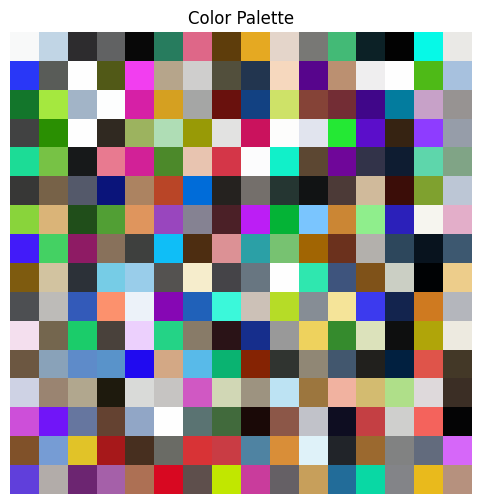

In [11]:
palette.shape# Ensure values are in [0, 1] for matplotlib

copy_palette = palette.clone()

if copy_palette.max() > 1.0:
    copy_palette = copy_palette / 255.0

# Compute size for square grid
num_colors = copy_palette.shape[0]
grid_size = int(math.ceil(math.sqrt(num_colors)))  # e.g., 23x23 for 512

# Pad if not a perfect square
padding = grid_size ** 2 - num_colors
if padding > 0:
    pad = torch.ones(padding, 3)  # white padding or change to zeros for black
    copy_palette = torch.cat([copy_palette, pad], dim=0)

# Reshape to [H, W, 3] for image plotting
palette_image = copy_palette.view(grid_size, grid_size, 3)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(palette_image)
plt.axis('off')
plt.title("Color Palette")
plt.show()

In [12]:
# Save palette
np.save("laion5b_palette_8bit.npy", palette.cpu().numpy())

# Save the palette to google drive
output_path = "/content/drive/MyDrive/laion/laion5b_palette_8bit.npy"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

np.save(output_path, palette.cpu().numpy())

In [13]:
# Load palette
palette = torch.tensor(np.load("laion5b_palette_8bit.npy"))

In [14]:
def quantize_batch_to_palette(images: torch.Tensor, palette: torch.Tensor) -> torch.Tensor:
    """
    Convert a batch of RGB images to use only colors from the given palette.

    Args:
        images: Tensor of shape [B, C, H, W], values in [0, 255]
        palette: Tensor of shape [K, 3], values in [0, 255]

    Returns:
        Tensor of shape [B, C, H, W], quantized images using colors from palette.
    """
    B, C, H, W = images.shape
    assert C == 3, "Expected 3 channels (RGB)"

    # Reshape to [B*H*W, 3]
    pixels = images.permute(0, 2, 3, 1).reshape(-1, 3).float()
    palette = palette.float()

    # Compute distances
    dists = torch.cdist(pixels, palette)  # [B*H*W, K]
    nearest_idx = torch.argmin(dists, dim=1)
    quantized_pixels = palette[nearest_idx]  # [B*H*W, 3]

    # Reshape back to [B, C, H, W]
    quantized = quantized_pixels.reshape(B, H, W, 3).permute(0, 3, 1, 2)
    return quantized.to(torch.uint8)


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


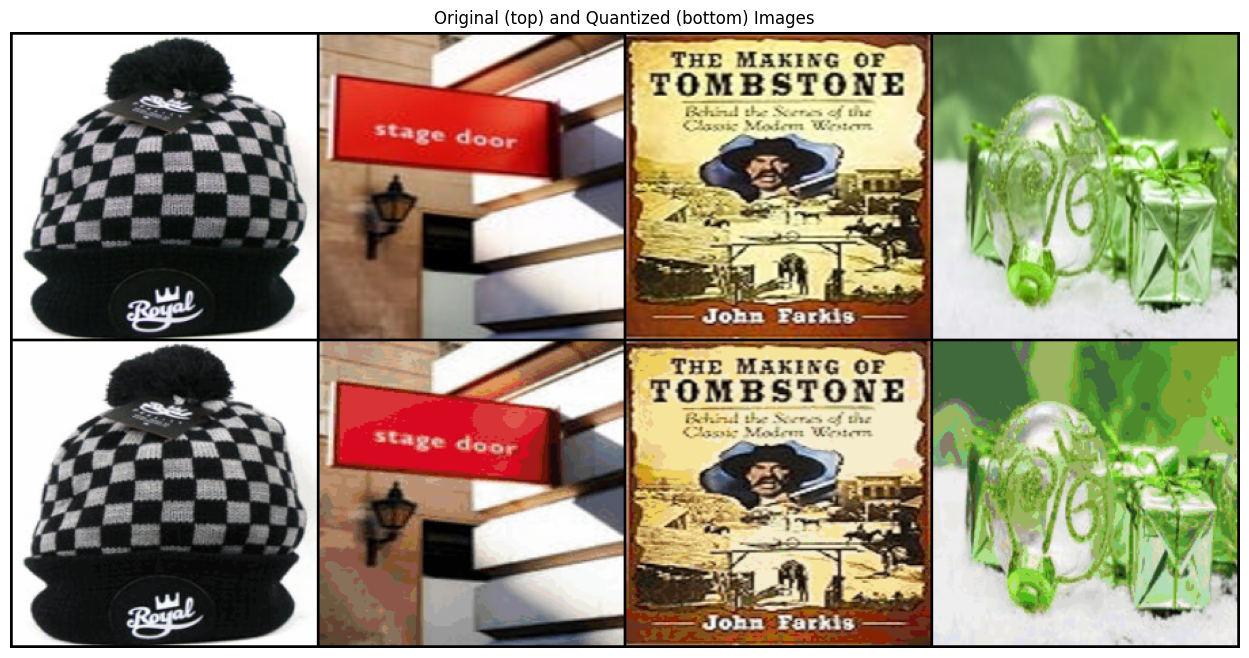

In [15]:
imgs, _ = next(iter(dataloader))

# Use 4 images from batch and scale to 0–255
imgs = ((imgs[:4] + 1) / 2) * 255
imgs = imgs.to(torch.uint8)

# Quantize the images using your palette
quants = quantize_batch_to_palette(imgs, palette)

# Stack original and quantized images vertically (along batch dimension)
stacked = torch.cat([imgs, quants], dim=0)  # shape: [8, C, H, W]

# Create grid: 4 images per row, so 2 rows
grid = torchvision.utils.make_grid(stacked, nrow=4)

# Rearrange for plotting
grid = rearrange(grid, "c h w -> h w c")

# Plot
plt.figure(figsize=(16, 8))
plt.imshow(grid)
plt.axis("off")
plt.title("Original (top) and Quantized (bottom) Images")
plt.show()


In [16]:
dataset.valid_images, dataset.invalid_images

(16677, 9247)